<a href="https://colab.research.google.com/github/Alexanderstaehle/OM_project/blob/dev-alex/Kopie_von_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import sys

sys.path.insert(1, r'/content/drive/My Drive/')

In [28]:
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchvision import utils

from utils import ml_utils
from utils import models
from utils.data_loading import initialize_env
from utils.data_loading import load_fashion_mnist, load_mnist

In [29]:
initialize_env()
device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)

## Looking at the data
Lets have a first look as to what the data looks like that we're dealing with

In [30]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([32, 1, 28, 28]) torch.Size([32])
labels:  Trouser, Pullover, Bag, Sandal, Pullover, Shirt, Ankle Boot, Ankle Boot, Ankle Boot, Coat, T-shirt/Top, Dress, Ankle Boot, Ankle Boot, Sandal, Shirt, Sneaker, Bag, Bag, Ankle Boot, Pullover, Shirt, Ankle Boot, Dress, T-shirt/Top, Sandal, T-shirt/Top, Sneaker, Shirt, Trouser, Pullover, T-shirt/Top, 

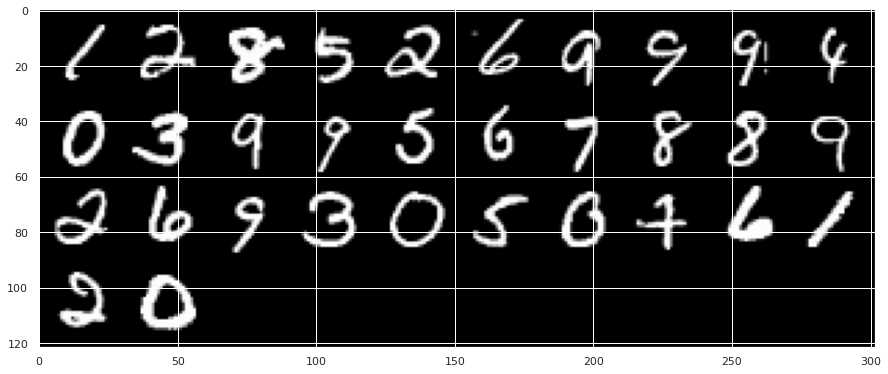

In [31]:
# demo_loader, _ = load_fashion_mnist(batch_size=10)
demo_loader, _ = load_mnist()

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)
grid = utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

## Different batchsizes at fixed learning rate

In [32]:
models_dict_fixed = {}
# batch_sizes = [32, 64, 128, 256, 512, 1024]
batch_sizes = [32, 64, 128]
lr = 0.001
training_epochs = 5

Epoch= 1,	 batch = 0,	 cost = 2.3036,	 accuracy = 0.09375
Epoch= 1,	 batch = 200,	 cost = 1.8134,	 accuracy = 0.6875
Epoch= 1,	 batch = 400,	 cost = 1.8149,	 accuracy = 0.625
Epoch= 1,	 batch = 600,	 cost = 1.7248,	 accuracy = 0.75
Epoch= 1,	 batch = 800,	 cost = 1.7462,	 accuracy = 0.71875
Epoch= 1,	 batch = 1000,	 cost = 1.5727,	 accuracy = 0.90625
Epoch= 1,	 batch = 1200,	 cost = 1.6970,	 accuracy = 0.75
Epoch= 1,	 batch = 1400,	 cost = 1.5043,	 accuracy = 0.96875
Epoch= 1,	 batch = 1600,	 cost = 1.7603,	 accuracy = 0.6875
Epoch= 1,	 batch = 1800,	 cost = 1.7430,	 accuracy = 0.71875
[Epoch:    1], averaged cost = 1.72760165
Epoch= 2,	 batch = 0,	 cost = 1.5888,	 accuracy = 0.875
Epoch= 2,	 batch = 200,	 cost = 1.6260,	 accuracy = 0.84375
Epoch= 2,	 batch = 400,	 cost = 1.6970,	 accuracy = 0.75
Epoch= 2,	 batch = 600,	 cost = 1.5414,	 accuracy = 0.9375
Epoch= 2,	 batch = 800,	 cost = 1.7631,	 accuracy = 0.71875
Epoch= 2,	 batch = 1000,	 cost = 1.5579,	 accuracy = 0.90625
Epoch= 2,	 b

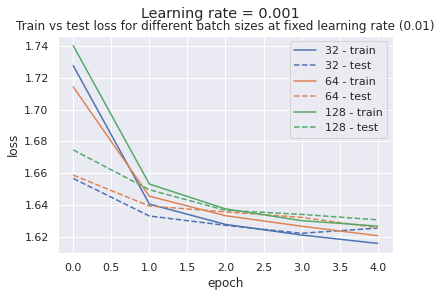

In [33]:
for i, batch_size in enumerate(batch_sizes):
    models_dict_fixed[batch_size] = {}
    train_dataloader, test_dataloader = load_fashion_mnist(batch_size=batch_size)
    model = models.MnistCnn()
    if device == "cuda":
        model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    results_dict = ml_utils.train(train_dataloader, test_dataloader, batch_size, model, optimizer, criterion, lr,
                                  training_epochs, device)
    models_dict_fixed[batch_size]["results"] = results_dict

    plt.plot(results_dict["train_loss"], label=f"{batch_size} - train", color=color_map[i])
    plt.plot(results_dict["test_loss"], label=f"{batch_size} - test", linestyle="--", color=color_map[i])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.suptitle('Train vs test loss for different batch sizes at fixed learning rate (0.01)')
plt.title(f'Learning rate = {lr}')
plt.legend()
plt.show()

## Different batchsizes with linear learning rate
Up the learning rate linearly according to the batch size.

In [34]:
models_dict_linear = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
training_epochs = 5

In [36]:
for i, (batch_size, lr) in enumerate(zip(batch_sizes, learning_rates)):
    models_dict_linear[batch_size] = {}
    train_dataloader, test_dataloader = load_fashion_mnist(batch_size=batch_size)
    model = models.MnistCnn()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    train_results_dict = ml_utils.train(train_dataloader, test_dataloader, batch_size, model, optimizer, criterion, lr,
                                        training_epochs, device)
    models_dict_linear[batch_size][lr] = train_results_dict

    plt.plot(results_dict["train_loss"], label=f"{batch_size} - {lr} - train", color=color_map[i])
    plt.plot(results_dict["test_loss"], label=f"{batch_size} - {lr} - test", linestyle="--", color=color_map[i])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train vs test loss for different batch sizes with linear increasing learning rate')
plt.legend()
plt.show()

RuntimeError: ignored

## SAM

In [ ]:
models_dict_sam = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 5

for i, batch_size in enumerate(batch_sizes):
    models_dict_sam[batch_size] = {}
    train_dataloader, test_dataloader = load_fashion_mnist(batch_size=batch_size)
    model = models.MnistCnn()
    if device == "cuda":
        model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD

    results_dict = ml_utils.train_sam(train_dataloader, test_dataloader, batch_size, model, optimizer, criterion, lr,
                                      training_epochs, device)
    models_dict_sam[batch_size]["results"] = results_dict

    plt.plot(results_dict["train_loss"], label=f"{batch_size} - train", color=color_map[i])
    plt.plot(results_dict["test_loss"], label=f"{batch_size} - test", linestyle="--", color=color_map[i])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train vs test loss for different batch sizes with SAM')
plt.legend()
plt.show()